# Causal Explanations in Models with Continuous Random Variables

The **Explainable Reasoning with Chirho** package aims to provide a unified, principled approach to computations of causal explanations. We showed in an earlier [tutorial](https://basisresearch.github.io/chirho/explainable_categorical.html) how Chirho provides a handler `SearchForExplanation` to carry out the program transformations needed to compute causal queries and explanations, focusing on on discrete variables (we assume the reader is familar with it). In this notebook we illustrate the usage of `SearchForExplanation` for causal models with continuous random variables in the context of a dynamical system.

We take an epidemiological dynamical system model (described in more detail in this [tutorial](https://basisresearch.github.io/chirho/dynamical_intro.html)) and show how the but-for analysis is not sufficiently fine-grained to allow us to derive the right conclusions about effects of different policies during a pandemic. Next, we illustrate how various causal explanation queries can be computed using `SearchForExplanation` and inference algorithms. We also demonstrate how more detailed causal queries can be answered by post-processing the samples obtained using the handler. 

## Outline

- [Setup](#Setup)
- [Bayesian epidemiological SIR model with Policies](#Bayesian-epidemiological-SIR-model-with-Policies)
    - [SIR Model and Simulation](#SIR-model-and-simulation)
    - [Bayesian SIR model](#Bayesian-SIR-model)
    - [Baysian SIR model with Policies](#Bayesian-SIR-model-with-policies)
- [But-for analysis for Bayesian SIR model with Policies](#But-for-Analysis-with-Bayesian-SIR-model-with-Policies)
- [Causal Explanations using `SearchForExplanation`](#Causal-Explanations-using-SearchForExplanation)
- [Fine-grained analysis for `overshoot` using sample traces](#Fine-grained-analysis-for-`overshoot`-using-sample-traces)
- [For advanced readers: Looking into different contexts](#for-advanced-readers-looking-into-different-contexts)


## Setup

The main dependencies for this example are PyTorch, Pyro, and ChiRho.


In [2]:
import numbers
import os
from typing import Tuple, TypeVar, Union, Optional, Callable
import math

import matplotlib.pyplot as plt
import pandas as pd
import pyro.distributions as dist
from pyro.distributions import constraints
import seaborn as sns
import torch
from pyro.infer import Predictive

import pyro
from chirho.counterfactual.handlers.counterfactual import \
    MultiWorldCounterfactual
from chirho.dynamical.handlers.interruption import StaticEvent
from chirho.dynamical.handlers.solver import TorchDiffEq
from chirho.dynamical.handlers.trajectory import LogTrajectory
from chirho.dynamical.ops import Dynamics, State, on, simulate
from chirho.explainable.handlers import SearchForExplanation
from chirho.explainable.handlers.components import ExtractSupports
from chirho.indexed.ops import IndexSet, gather, indices_of
from chirho.interventional.ops import Intervention, intervene
from chirho.observational.handlers import condition

R = Union[numbers.Real, torch.Tensor]
S = TypeVar("S")
T = TypeVar("T")


sns.set_style("white")

seed = 123
pyro.clear_param_store()
pyro.set_rng_seed(seed)

smoke_test = "CI" in os.environ
num_samples = 10 if smoke_test else 300
exp_plate_size = 10 if smoke_test else 2000

## Bayesian Epidemiological SIR model with Policies

Now, we build the epidemiological SIR (Susceptible, Infected, Recovered/Removed) model, one step at a time. We first encode the deterministic SIR dynamics. Then we add uncertainty about the parameters that govern these dynamics - $\beta$ and $\gamma$. These parameters have been described in much detail in the [dynamical systems tutorial](https://basisresearch.github.io/chirho/dynamical_intro.html). We then incorporate the resulting model into a more complex causal model that describes the policy mechanisms such as imposing lockdown and masking restrictions.

Our outcome of interest is overshoot, the proportion of the population that remains susceptible after the epidemic peak but eventually becomes infected as the epidemic continues. One way to compute it is to:

1. Find the time at which the number of infected individuals is at its peak, `t_max`.
2. Determine the proportion of susceptibles at `t_max` in the whole population, `S_peak`.
3. Find the proportion of susceptibles (those not infected) at the end of the logging period, `S_final`.
4. Calculate the additional ratio of infected individuals since the peak as `S_peak - S_final`.

This quantity is of interest because epidemic mitigation policies often have multiple goals that need to be balanced. One goal is to increase `S_final`, i.e., to limit the total number of infected individuals. Another goal is to limit the number of infected individuals at the peak of the epidemic to avoid overwhelming the healthcare system. A further goal is to minimize the proportion of the population that becomes infected after the peak, that is, the overshoot, to reduce healthcare and economic burdens. Balancing these objectives involves making trade-offs.

 Suppose we are working under constraint that the overshoot show be lower than 20% of the population, and we implement two policies, lockdown and masking, which together seem to lead to the overshoot being too high. In fact, only one of them is responsible, and we are interested in being able to identify which one. 

### SIR Model and Simulation

In [6]:
# dS = - beta . SI
# dI = beta * SI - gamma * I
# dR = gamma * I

class SIRDynamics(pyro.nn.PyroModule):
    def __init__(self, beta, gamma):
        super().__init__()
        self.beta = beta
        self.gamma = gamma

    def forward(self, X: State[torch.Tensor]):
        dX: State[torch.Tensor] = dict()
        dX["S"] = -self.beta * X["S"] * X["I"]
        dX["I"] = self.beta * X["S"] * X["I"] - self.gamma * X["I"]
        dX["R"] = self.gamma * X["I"]

        return dX


# l is a parameter describing the strenght of the intervening policies 
# it is a value between 0 and 1, and (1-l) is the fraction of the original unintervened beta
class SIRDynamicsPolicies(SIRDynamics):
    def __init__(self, beta0, gamma):
        super().__init__(beta0, gamma)
        self.beta0 = beta0

    def forward(self, X: State[torch.Tensor]):
        self.beta = (1 - X["l"]) * self.beta0
        dX = super().forward(X)
        dX["l"] = torch.zeros_like(X["l"])
        return dX

In [8]:
# Computing overshoot in a simple SIR model without interventions
# note it's below the desired threshold

init_state = dict(S=torch.tensor(99.0), I=torch.tensor(1.0), R=torch.tensor(0.0))
start_time = torch.tensor(0.0)
end_time = torch.tensor(12.0)
step_size = torch.tensor(0.1)
logging_times = torch.arange(start_time, end_time, step_size)
init_state_lockdown = dict(**init_state, l=torch.tensor(0.0))

# We now simulate from the SIR model
beta_true = torch.tensor([0.03])
gamma_true = torch.tensor([0.5])
sir_true = SIRDynamics(beta_true, gamma_true)
with TorchDiffEq(), LogTrajectory(logging_times) as lt:
    simulate(sir_true, init_state, start_time, end_time)

sir_true_traj = lt.trajectory


def get_overshoot(trajectory):
    t_max = torch.argmax(trajectory["I"].squeeze())
    S_peak = torch.max(trajectory["S"].squeeze()[t_max]) / 100
    S_final = trajectory["S"].squeeze()[-1] / 100
    return (S_peak - S_final).item()


print(get_overshoot(sir_true_traj))

0.15116800367832184


The number $0.15$ is the overshoot you get if $\beta = 0.03, \gamma = 0.5$. This value is observed by simulating the SIR dynamics model with these values and calculate overshoot directly.

### Bayesian SIR model

Now suppose we are uncertain about $\beta, \gamma$, and want to construct a Bayesian SIR model that incorporates this uncertainty. Say we inducing $\beta$ to be drawn from `Beta(18, 600)`, and $\gamma$ to be drawn from distribution `Beta(1600, 1600)`. 

In [9]:
# Defining a Bayesian SIR model where we have priors over beta and gamma distributions

def bayesian_sir(base_model=SIRDynamics) -> Dynamics[torch.Tensor]:
    beta = pyro.sample("beta", dist.Beta(18, 600))
    gamma = pyro.sample("gamma", dist.Beta(1600, 1600))
    sir = base_model(beta, gamma)
    return sir


def simulated_bayesian_sir(
    init_state, start_time, logging_times, base_model=SIRDynamics
) -> State[torch.Tensor]:
    sir = bayesian_sir(base_model)

    with TorchDiffEq(), LogTrajectory(logging_times, is_traced=True) as lt:
        simulate(sir, init_state, start_time, logging_times[-1])
    return lt.trajectory

### Bayesian SIR model with Policies

Now we incorporate the Bayesian SIR model into a larger model that includes the effect of two different policies, lockdown and masking, where each can be implemented with $50\%$ probability (these probabilities won't really matter, as we will be intervening on these, the sampling is mainly used to register the parameters with Pyro). We encode their efficiencies which further affect the model. Crucially, these efficiencies interact in a fashion resembling the structure of the stone-throwing example we discussed in the tutorial on categorical variables. If lockdown is present, this limits the impact of masking as agents interact less and so masks have fewer opportunities to block anything. We assume the situation is assymetric: masking has no impact on the efficiency of lockdown. The model also computes `overshoot` and `os_too_high` for further analysis.



In [11]:
# a utility function 
# allowing for interventions on a dynamical system
# within another model

def MaskedStaticIntervention(time: R, intervention: Intervention[State[T]]):

    @on(StaticEvent(time))
    def callback(
        dynamics: Dynamics[T], state: State[T]
    ) -> Tuple[Dynamics[T], State[T]]:

        with pyro.poutine.block():
            return dynamics, intervene(state, intervention)

    return callback

In [12]:
# Defining the policy model

overshoot_threshold = 20
lockdown_time = torch.tensor(1.0)
mask_time = torch.tensor(1.5)


def policy_model():

    lockdown = pyro.sample("lockdown", dist.Bernoulli(torch.tensor(0.5)))
    mask = pyro.sample("mask", dist.Bernoulli(torch.tensor(0.5)))

    lockdown_efficiency = pyro.deterministic(
        "lockdown_efficiency", torch.tensor(0.6) * lockdown, event_dim=0
    )

    mask_efficiency = pyro.deterministic(
        "mask_efficiency", (0.1 * lockdown + 0.45 * (1 - lockdown)) * mask, event_dim=0
    )

    joint_efficiency = pyro.deterministic(
        "joint_efficiency",
        torch.clamp(lockdown_efficiency + mask_efficiency, 0, 0.95),
        event_dim=0,
    )

    lockdown_sir = bayesian_sir(SIRDynamicsPolicies)
    with LogTrajectory(logging_times, is_traced=True) as lt:
        with TorchDiffEq():
            with MaskedStaticIntervention(lockdown_time, dict(l=lockdown_efficiency)):
                with MaskedStaticIntervention(mask_time, dict(l=joint_efficiency)):
                    simulate(
                        lockdown_sir, init_state_lockdown, start_time, logging_times[-1]
                    )

    trajectory = lt.trajectory

    t_max = torch.max(trajectory["I"], dim=-1).indices
    S_peaks = pyro.ops.indexing.Vindex(trajectory["S"])[..., t_max]
    overshoot = pyro.deterministic(
        "overshoot", S_peaks - trajectory["S"][..., -1], event_dim=0
    )
    os_too_high = pyro.deterministic(
        "os_too_high",
        (overshoot > overshoot_threshold).clone().detach().float(),
        event_dim=0,
    )

    return overshoot, os_too_high

## But-for Analysis with Bayesian SIR model with Policies

Suppose now we introduced both policies, and this resulted in an overshoot. What intuitively is the case is that lockdown limited the efficiency of masking, and it was in fact the lockdown that in this particular context caused the overshoot (this is consistent with saying that in the context where only masking has been implemented, masking would be responsible for the resulting overshoot being too high).

We might try to use the but-for analysis to idenitfy which of the policies causes overshoot to be too high. To do so, we investigate the following four scenarios:

1. None of the policies were applied
2. Both lockdown and masking were enforced
3. Only masking was imposed
4. Only lockdown was imposed

The hope is that by looking at these we will be able to indentify the culprit. We create these four models by conditioning on the policies being imposed as required (in fact, this has the same effect as intervening here, as the sites are upstream from the model). The models obtained are similar to the intervened models since the variables `lockdown` and `mask` do not have any variables upstream to them. In principle we could emulate 1-4 using `do` with the same estimates. For the sake of completeness, we also illustrate the consequences of deciding randomly about the policies.

In [15]:
# conditioning (as opposed to intervening) is sufficient for
# propagating the changes, as the decisions are upstream from ds


# no interventions
num_samples = 10000
policy_model_none = condition(
    policy_model, {"lockdown": torch.tensor(0.0), "mask": torch.tensor(0.0)}
)
unintervened_predictive = Predictive(
    policy_model_none, num_samples=num_samples, parallel=True
)
unintervened_samples = unintervened_predictive()

# both interventions
policy_model_all = condition(
    policy_model, {"lockdown": torch.tensor(1.0), "mask": torch.tensor(1.0)}
)
intervened_predictive = Predictive(
    policy_model_all, num_samples=num_samples, parallel=True
)
intervened_samples = intervened_predictive()

policy_model_mask = condition(
    policy_model, {"lockdown": torch.tensor(0.0), "mask": torch.tensor(1.0)}
)
mask_predictive = Predictive(policy_model_mask, num_samples=num_samples, parallel=True)
mask_samples = mask_predictive()

policy_model_lockdown = condition(
    policy_model, {"lockdown": torch.tensor(1.0), "mask": torch.tensor(0.0)}
)
lockdown_predictive = Predictive(
    policy_model_lockdown, num_samples=num_samples, parallel=True
)
lockdown_samples = lockdown_predictive()

predictive = Predictive(
    policy_model, num_samples=num_samples, parallel=True
)
samples = predictive()

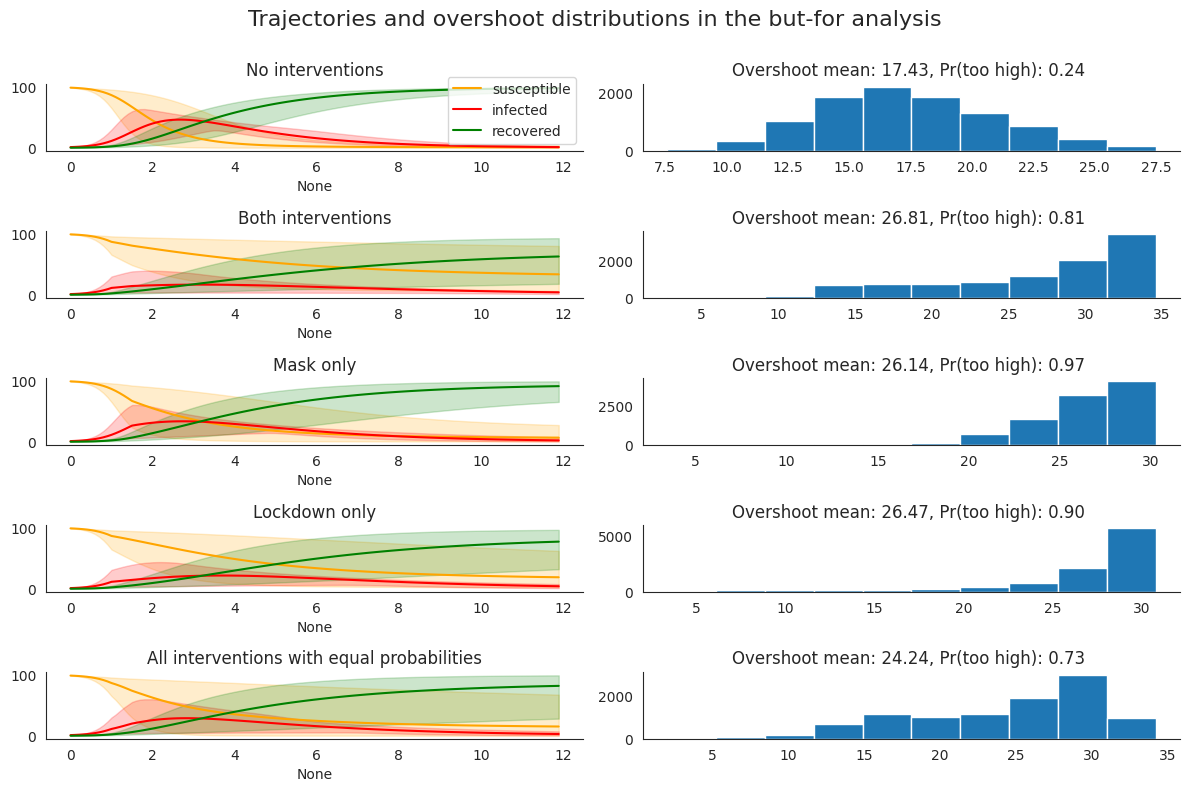

In [17]:
def add_pred_to_plot(preds, axs, coords, color, label):
    sns.lineplot(
        x=logging_times,
        y=preds.mean(dim=0).squeeze().tolist(),
        ax=axs[coords],
        label=label,
        color=color,
    )
    axs[coords].fill_between(
        logging_times,
        torch.quantile(preds, 0.025, dim=0).squeeze(),
        torch.quantile(preds, 0.975, dim=0).squeeze(),
        alpha=0.2,
        color=color,
    )


fig, axs = plt.subplots(5, 2, figsize=(12, 7.5))

colors = ["orange", "red", "green"]

add_pred_to_plot(
    unintervened_samples["S"], axs, coords=(0, 0), color=colors[0], label="susceptible"
)
add_pred_to_plot(
    unintervened_samples["I"], axs, coords=(0, 0), color=colors[1], label="infected"
)
add_pred_to_plot(
    unintervened_samples["R"], axs, coords=(0, 0), color=colors[2], label="recovered"
)

axs[0, 1].hist(unintervened_samples["overshoot"].squeeze())
axs[0, 0].set_title("No interventions")
axs[0, 1].set_title(
    f"Overshoot mean: {unintervened_samples['overshoot'].squeeze().mean().item():.2f}, Pr(too high): {unintervened_samples['os_too_high'].squeeze().float().mean().item():.2f} "
)


add_pred_to_plot(
    intervened_samples["S"], axs, coords=(1, 0), color=colors[0], label="susceptible"
)
add_pred_to_plot(
    intervened_samples["I"], axs, coords=(1, 0), color=colors[1], label="infected"
)
add_pred_to_plot(
    intervened_samples["R"], axs, coords=(1, 0), color=colors[2], label="recovered"
)
axs[1, 0].set_title("Both interventions")
axs[1, 0].legend_.remove()


axs[1, 1].hist(intervened_samples["overshoot"].squeeze())
axs[1, 1].set_title(
    f"Overshoot mean: {intervened_samples['overshoot'].squeeze().mean().item():.2f}, Pr(too high): {intervened_samples['os_too_high'].squeeze().float().mean().item():.2f} "
)


add_pred_to_plot(
    mask_samples["S"], axs, coords=(2, 0), color=colors[0], label="susceptible"
)
add_pred_to_plot(
    mask_samples["I"], axs, coords=(2, 0), color=colors[1], label="infected"
)
add_pred_to_plot(
    mask_samples["R"], axs, coords=(2, 0), color=colors[2], label="recovered"
)
axs[2, 0].set_title("Mask only")
axs[2, 0].legend_.remove()

axs[2, 1].hist(mask_samples["overshoot"].squeeze())
axs[2, 1].set_title(
    f"Overshoot mean: {mask_samples['overshoot'].squeeze().mean().item():.2f}, Pr(too high): {mask_samples['os_too_high'].squeeze().float().mean().item():.2f} "
)

add_pred_to_plot(
    lockdown_samples["S"], axs, coords=(3, 0), color=colors[0], label="susceptible"
)
add_pred_to_plot(
    lockdown_samples["I"], axs, coords=(3, 0), color=colors[1], label="infected"
)
add_pred_to_plot(
    lockdown_samples["R"], axs, coords=(3, 0), color=colors[2], label="recovered"
)
axs[3, 0].set_title("Lockdown only")
axs[3, 0].legend_.remove()

axs[3, 1].hist(lockdown_samples["overshoot"].squeeze())
axs[3, 1].set_title(
    f"Overshoot mean: {lockdown_samples['overshoot'].squeeze().mean().item():.2f}, Pr(too high): {lockdown_samples['os_too_high'].squeeze().float().mean().item():.2f} "
)

add_pred_to_plot(
    samples["S"], axs, coords=(4, 0), color=colors[0], label="susceptible"
)
add_pred_to_plot(
    samples["I"], axs, coords=(4, 0), color=colors[1], label="infected"
)
add_pred_to_plot(
    samples["R"], axs, coords=(4, 0), color=colors[2], label="recovered"
)
axs[4, 0].set_title("All interventions with equal probabilities")
axs[4, 0].legend_.remove()

axs[4, 1].hist(samples["overshoot"].squeeze())
axs[4, 1].set_title(
    f"Overshoot mean: {samples['overshoot'].squeeze().mean().item():.2f}, Pr(too high): {samples['os_too_high'].squeeze().float().mean().item():.2f} "
)


fig.tight_layout()
fig.suptitle("Trajectories and overshoot distributions in the but-for analysis", fontsize=16, y=1.05)
sns.despine()

plt.savefig("counterfactual_sir.png")

The plots above show what happens in the four different scenarios. We observe that in the model where none of the policies were imposed, ther probability of the overshoot being too high is relatively low, $0.24$. On the other hand, when both policies were imposed, the probability of the overshoot being to high was relatively higher $0.81$. 

To identify which of `lockdown` and `mask` is the cause, we analyze the models where only one of the policies were imposed. In both cases, the probability of too high overshoot seems to be even higher - $0.96$ and $0.9$. Interestingly, the effect of the interventions is somewhat nuanced. Implementing both increases the risk of overshoot as compared to the no intervention model. But individual intereventions would have even worse consequences, which means that the two interventions while jointly increasing the risk to some extent mitigate each other's contribution to that risk as well.

Crucially, the analysis does not allow us to distinghuish the intuitive role that the lockdown played, as opposed to masking (whose impact has been limited by the presence of lockdown). So, we need of a more fine-grained analysis where we not only control the variables being intervened on (that is, the policies), but also pay attention to what context we are in. We achieve that level of sensitivity by stochastically keeping part of the context (that is, other variables in the model) fixed (see the tutorial for categorical variables for a more extensive explanation of this method and simpler examples). The key idea is that starting with the scenario in which both interventions have been implemented, there is a context such that if we keep it fixed, removing lockdown would significantly lower the overshoot, but there is no context that we could keep fixed such that if in that context we remove the masking policy, the overshoot would decrease. In the next section, we show how this analysis can be carried out with the help of `SearchForExplanation`.

## Causal Explanations using `SearchForExplanation`

We first setup a function for performing importance sampling through the model that returns cumulative log probabilities of the samples, sample traces, handler for multiworld counterfactual reasoning and log probabilities. We use these objects later in the code to subselect the samples.

In [511]:
def importance_infer(
    model: Optional[Callable] = None, *, num_samples: int
):
    
    if model is None:
        return lambda m: importance_infer(m, num_samples=num_samples)

    def _wrapped_model(
        *args,
        **kwargs
    ):

        guide = pyro.poutine.block(hide_fn=lambda msg: msg["is_observed"])(model)

        max_plate_nesting = 9  # TODO guess

        with pyro.poutine.block(), MultiWorldCounterfactual() as mwc_imp:
            log_weights, importance_tr, _ = pyro.infer.importance.vectorized_importance_weights(
                model,
                guide,
                *args,
                num_samples=num_samples,
                max_plate_nesting=max_plate_nesting,
                normalized=False,
                **kwargs
            )

        return torch.logsumexp(log_weights, dim=0) - math.log(num_samples), importance_tr, mwc_imp, log_weights

    return _wrapped_model

Then, we setup the query as follows:
1. `supports`: We extract supports of the model using `ExtractSupports` and enrich it with additional information of `os_too_high` being a Boolean.
2. `antecedents`: We have put `lockdown=1` and `mask=1` as possible causes.
3. `alternatives`: We provide `lockdown=0` and `mask=0` as alternative values.
4. `witnesses`: We include `mask_efficiency` and `lockdown_efficiency` as candidates to be included in the context to be kept fixed.
5. `consequents`: We put `os_too_high=1` as the outcome we wish to analyze the causes for.
6. `antecedent_bias`, `witness_bias`, `consequent_scale`: We set these parameters to have equal probabilities of choosing causes and preferring minimal witness sets. Please refer to the documentation of `SearchForExplanation` for more details.

In [512]:
with ExtractSupports() as s:
    policy_model()

supports = s.supports
supports["os_too_high"] = constraints.independent(base_constraint=constraints.boolean, reinterpreted_batch_ndims=0)

query = SearchForExplanation(
            supports=supports,
            alternatives={"lockdown": torch.tensor(0.0), "mask": torch.tensor(0.0)},
            antecedents={"lockdown": torch.tensor(1.0), "mask": torch.tensor(1.0)},
            antecedent_bias=0.0,
            witnesses={key: s.supports[key] for key in ["lockdown_efficiency", "mask_efficiency"]},
            consequents={"os_too_high": torch.tensor(1.0)},
            consequent_scale=1e-8,
            witness_bias=0.2,
        )(policy_model #it was policy_model_all earlier)
        )

logp, importance_tr, mwc_imp, log_weights = importance_infer(num_samples=10000)(query)()
print(torch.exp(logp))

tensor(0.1215)


Now that we have setup the query and drawn 10000 samples from it, we can analyze the samples and their log probabilities to compute queries of interest. We first compute the probabilities that different sets of antecedent candidates have causal effect over `os_too_high`.

In [513]:
def compute_prob(trace, log_weights, mask):
    mask_intervened = torch.ones(trace.nodes["__cause____antecedent_lockdown"]["value"].shape).bool()
    for i, v in mask.items():
        mask_intervened &= (trace.nodes[i]["value"] == v)
    print(mask, (torch.sum(torch.exp(log_weights) * mask_intervened.squeeze()) / mask_intervened.float().sum()).item())

In [514]:
compute_prob(importance_tr, log_weights, {"__cause____antecedent_lockdown": 0, "__cause____antecedent_mask": 0})
compute_prob(importance_tr, log_weights, {"__cause____antecedent_lockdown": 0, "__cause____antecedent_mask": 1})
compute_prob(importance_tr, log_weights, {"__cause____antecedent_lockdown": 1, "__cause____antecedent_mask": 0})
compute_prob(importance_tr, log_weights, {"__cause____antecedent_lockdown": 1, "__cause____antecedent_mask": 1})

{'__cause____antecedent_lockdown': 0, '__cause____antecedent_mask': 0} 0.19823434948921204
{'__cause____antecedent_lockdown': 0, '__cause____antecedent_mask': 1} 0.1833265870809555
{'__cause____antecedent_lockdown': 1, '__cause____antecedent_mask': 0} 0.10898739099502563
{'__cause____antecedent_lockdown': 1, '__cause____antecedent_mask': 1} 2.7269246860583962e-09


Note that one can also compute above queries by giving specific parameters to `SearchForExplanation` instead of subselecting the samples as we did in the tutorial for explainable module for models with categorical variables.

Also, we use the log probabilities above to identify whether a particular combination of intervening nodes and context nodes have causal power or not. One can also obatin these results by explictly analyzing the sample trace as we do in the next section.

We can also compute degree of responsibilities assigned to both lockdown and mask as follows:

In [515]:
print("Degree of responsibility for lockdown: ")
compute_prob(importance_tr, log_weights, {"__cause____antecedent_lockdown": 0})
print()

print("Degree of responsibility for mask: ")
compute_prob(importance_tr, log_weights, {"__cause____antecedent_mask": 0})

Degree of responsibility for lockdown: 
{'__cause____antecedent_lockdown': 0} 0.19081200659275055

Degree of responsibility for mask: 
{'__cause____antecedent_mask': 0} 0.15390829741954803


Further notebook is still work in progress. Some questions I had:
1. Normalization of degree of responsibility is not super clear to me that why we would want to do that.
2. The plots below are updated with `policy_model` instead of `policy_model_all`.

## Fine grained analysis of `overshoot` using sample traces

In this section, we use the samples we obtained earlier to analyze the distribution of `overshoot` variable in different counterfactual worlds. We first define a function to obtain histogram data from the samples in a particular world and then we demonstrate the plots for `overshoot` distribution in different settings.

In [516]:
def histogram_data(trace, mwc, masks, world):
    with mwc:
        data_to_plot = gather(trace.nodes["overshoot"]["value"], IndexSet(**{"lockdown": {world}, "mask": {world}}))

        mask_tensor = torch.ones(importance_tr.nodes["__cause____antecedent_mask"]["value"].shape).bool()
        for key, val in masks.items():
            mask_tensor = mask_tensor & (trace.nodes[key]["value"] == val)
        data_to_plot = data_to_plot.squeeze()[torch.nonzero(mask_tensor.squeeze())]

        os_too_high = (gather(trace.nodes["os_too_high"]["value"], IndexSet(**{"lockdown": {world}, "mask": {world}})))
        os_too_high = os_too_high.squeeze()[torch.nonzero(mask_tensor.squeeze())]

        overshoot_mean = data_to_plot.mean()
        os_too_high_mean = os_too_high.mean()

    hist, bin_edges = torch.histogram(data_to_plot, bins = 28, range=(5, 40), density=True)
    return hist, bin_edges, overshoot_mean, os_too_high_mean


We first plot the distribution of `overshoot` in the factual world (indicated by 0) and necessity counterfactual worlds (indicated by 1) where intervened variables are set to their alternative value. One can see how the distribution changes in the counterfactual worlds. When `mask` is set to 0, the probability of high overshoot is lower than that when `lockdown` is set to 0. This provides us the intuition that `lockdown` has a higher role in inducing high overshoot.

In [517]:
hist_fact_nec, bin_edges, os_fact_nec, oth_fact_nec = histogram_data(importance_tr, mwc_imp, {}, 0)
hist_mask_nec, bin_edges, os_mask_nec, oth_mask_nec = histogram_data(importance_tr, mwc_imp, {"__cause____antecedent_mask": 0, "__cause____antecedent_lockdown": 1, "__cause____witness_mask_efficiency": 0}, 1)
hist_lockdown_nec, bin_edges, os_lockdown_nec, oth_lockdown_nec = histogram_data(importance_tr, mwc_imp, {"__cause____antecedent_mask": 1, "__cause____antecedent_lockdown": 0, "__cause____witness_lockdown_efficiency": 0}, 1)

Overshoot mean
factual:  24.31097984313965  counterfactual mask:  21.902610778808594  counterfactual lockdown:  20.758800506591797
Probability of overshoot being high
factual:  0.7299000024795532  counterfactual mask:  0.5736842155456543  counterfactual lockdown:  0.5078909397125244


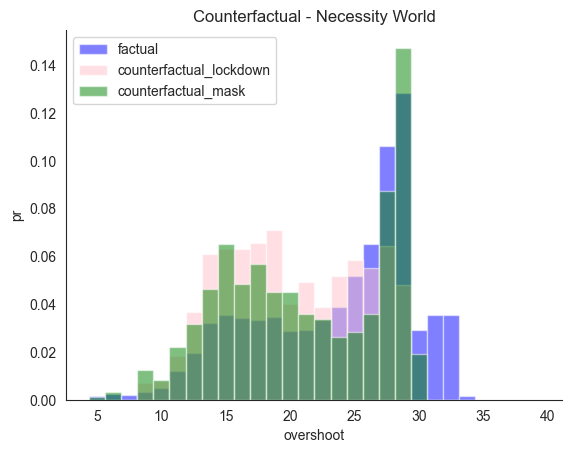

In [518]:
plt.bar(bin_edges[:28].tolist(), hist_fact_nec, align='center', width = 35/28, alpha = 0.5, color='blue')
plt.bar(bin_edges[:28].tolist(), hist_lockdown_nec, align='center', width = 35/28, alpha = 0.5, color='pink')
plt.bar(bin_edges[:28].tolist(), hist_mask_nec, align='center', width = 35/28, alpha = 0.5, color='green')
plt.legend(["factual", "counterfactual_lockdown", "counterfactual_mask"])
plt.ylabel("pr")
plt.xlabel("overshoot")
plt.title("Counterfactual - Necessity World")
sns.despine()

print("Overshoot mean")
print("factual: ", os_fact_nec.item(), " counterfactual mask: ", os_mask_nec.item(), " counterfactual lockdown: ", os_lockdown_nec.item())

print("Probability of overshoot being high")
print("factual: ", oth_fact_nec.item(), " counterfactual mask: ", oth_mask_nec.item(), " counterfactual lockdown: ", oth_lockdown_nec.item())

We can have similar plots for sufficiency worlds (indicated by 2) where variables are intervened on to be their antecedent value. The resulting plots show that when `mask` is set to be 1, there is a higher probability of high overshoot but the distribution is more flat as compared to the distribution when `lockdown` is set to `, that has higher peaks.

In [519]:
hist_fact_suff, bin_edges, os_fact_suff, oth_fact_suff = histogram_data(importance_tr, mwc_imp, {}, 0)
hist_mask_suff, bin_edges, os_mask_suff, oth_mask_suff = histogram_data(importance_tr, mwc_imp, {"__cause____antecedent_mask": 0, "__cause____antecedent_lockdown": 1, "__cause____witness_mask_efficiency": 0}, 2)
hist_lockdown_suff, bin_edges, os_lockdown_suff, oth_lockdown_suff = histogram_data(importance_tr, mwc_imp, {"__cause____antecedent_mask": 1, "__cause____antecedent_lockdown": 0, "__cause____witness_lockdown_efficiency": 0}, 2)

Overshoot mean
factual:  24.31097984313965  counterfactual mask:  26.651079177856445  counterfactual lockdown:  22.560808181762695
Probability of overshoot being high
factual:  0.7299000024795532  counterfactual mask:  0.8868421316146851  counterfactual lockdown:  0.7044476270675659


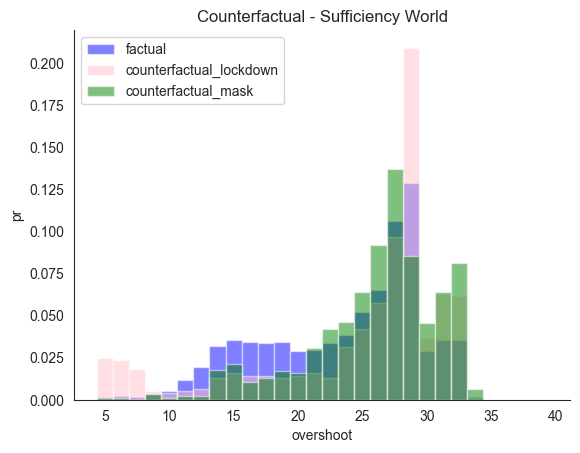

In [520]:
plt.bar(bin_edges[:28].tolist(), hist_fact_suff, align='center', width = 35/28, alpha = 0.5, color='blue')
plt.bar(bin_edges[:28].tolist(), hist_lockdown_suff, align='center', width = 35/28, alpha = 0.5, color='pink')
plt.bar(bin_edges[:28].tolist(), hist_mask_suff, align='center', width = 35/28, alpha = 0.5, color='green')
plt.legend(["factual", "counterfactual_lockdown", "counterfactual_mask"])
plt.ylabel("pr")
plt.xlabel("overshoot")
plt.title("Counterfactual - Sufficiency World")
sns.despine()

print("Overshoot mean")
print("factual: ", os_fact_suff.item(), " counterfactual mask: ", os_mask_suff.item(), " counterfactual lockdown: ", os_lockdown_suff.item())

print("Probability of overshoot being high")
print("factual: ", oth_fact_suff.item(), " counterfactual mask: ", oth_mask_suff.item(), " counterfactual lockdown: ", oth_lockdown_suff.item())

We can also try to combine samples from both sufficiency and necessity worlds to draw conclusions. We first visualize samples where only lockdown was intervened on and then we analyze samples where masking was intervened on.

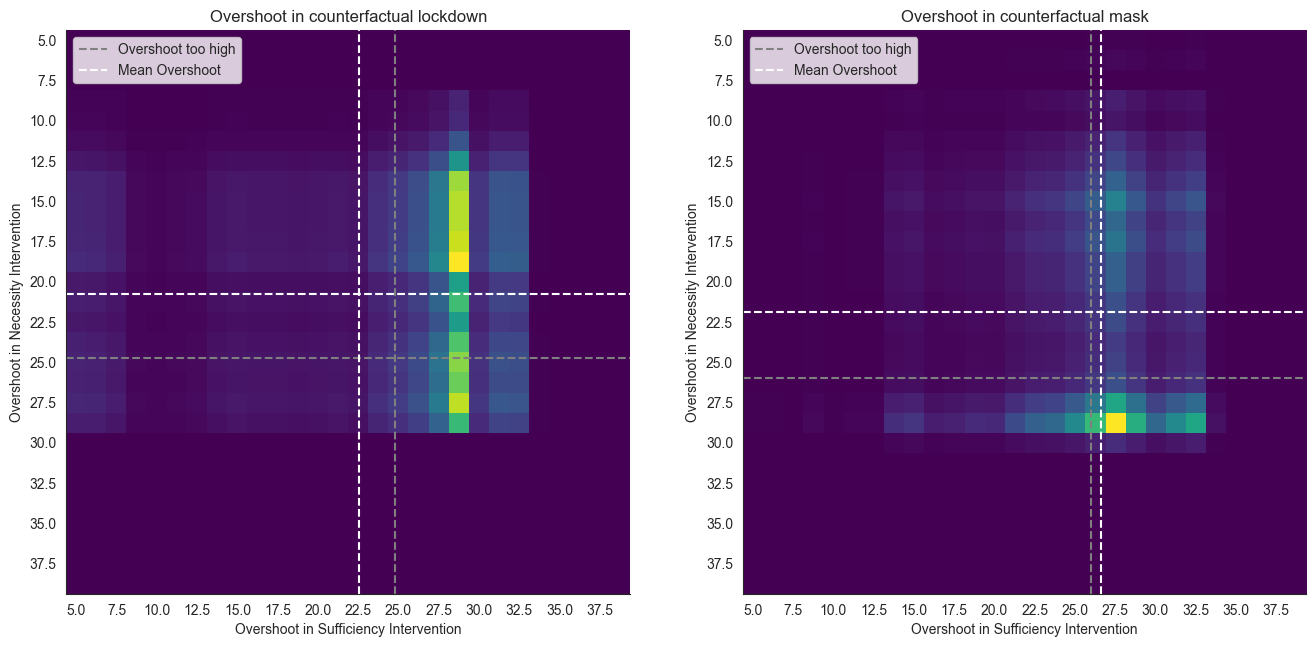

In [521]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

ax = axs[0]
hist_lockdown = hist_lockdown_nec.unsqueeze(1) * hist_lockdown_suff.unsqueeze(0)
ax.imshow(hist_lockdown, cmap = "viridis")
ax.set(xticks = range(0, 28, 2), xticklabels = bin_edges[0:28:2].tolist())
ax.set(yticks = range(0, 28, 2), yticklabels = bin_edges[0:28:2].tolist())
ax.set(xlabel = "Overshoot in Sufficiency Intervention", ylabel = "Overshoot in Necessity Intervention", title="Overshoot in counterfactual lockdown")
ax.axvline(x=15.8, color="grey", linestyle="--", label = "Overshoot too high")
ax.axhline(y=15.8, color="grey", linestyle="--")

ax.axvline(x=(os_lockdown_suff-5)*28/35, color="white", linestyle="--", label = "Mean Overshoot")
ax.axhline(y=(os_lockdown_nec-5)*28/35, color="white", linestyle="--")

ax.legend(loc = "upper left")

ax = axs[1]
hist_mask = hist_mask_nec.unsqueeze(1) * hist_mask_suff.unsqueeze(0)
ax.imshow(hist_mask, cmap = "viridis")
ax.set(xticks = range(0, 28, 2), xticklabels = bin_edges[0:28:2].tolist())
ax.set(yticks = range(0, 28, 2), yticklabels = bin_edges[0:28:2].tolist())
ax.set(xlabel = "Overshoot in Sufficiency Intervention", ylabel = "Overshoot in Necessity Intervention", title="Overshoot in counterfactual mask")
ax.axvline(x=16.8, color="grey", linestyle="--", label = "Overshoot too high")
ax.axhline(y=16.8, color="grey", linestyle="--")

ax.axvline(x=(os_mask_suff-5)*28/35, color="white", linestyle="--", label = "Mean Overshoot")
ax.axhline(y=(os_mask_nec-5)*28/35, color="white", linestyle="--")

ax.legend(loc = "upper left")

sns.despine()

It is evident from the plot above that counterfactual for lockdown has more probability mask in the top right quadrant (low overshoot in necessity world and high overshoot in sufficient world). This gives us a more clear picture into why lockdown has more causal role in overshoot being too high as compared to masking.

## For advanced readers: Looking into different contexts

`SearchForExplanation` allows the users to perform an even finer grained analysis by visualizing distributions of random variables when different contexts are kept fixed in the model. To illustrate this, we consider the following two scenarios:
1. Intervene on `lockdown=1` while keeping `mask_efficiency` fixed or not.
2. Intervene on `mask=1` while keeping `lockdown_efficiency` fixed or not.

We first intervene on `lockdown` being 1 and analyze how the distribution of `overshoot` change as we keep the `mask_efficiency` fixed or not.

In [522]:
hist_lockdown_fix, bin_edges, os_lockdown_fix, oth_lockdown_fix = histogram_data(importance_tr, mwc_imp, {"__cause____antecedent_mask": 1, "__cause____antecedent_lockdown": 0, "__cause____witness_lockdown_efficiency": 0, "__cause____witness_mask_efficiency": 1}, 1)
hist_lockdown_notfix, bin_edges, os_lockdown_notfix, oth_lockdown_notfix = histogram_data(importance_tr, mwc_imp, {"__cause____antecedent_mask": 1, "__cause____antecedent_lockdown": 0, "__cause____witness_lockdown_efficiency": 0, "__cause____witness_mask_efficiency": 0}, 1)

Overshoot mean
mask_efficiency fixed:  20.179100036621094  mask_efficiency not fixed:  22.04108238220215
Probability of overshoot being high
mask_efficiency fixed:  0.4541666805744171  mask_efficiency not fixed:  0.6267281174659729


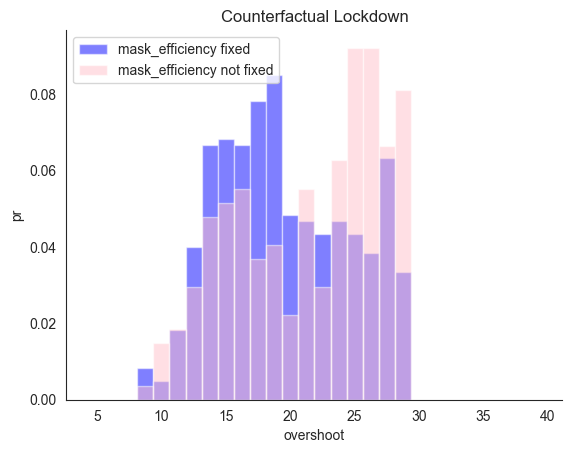

In [523]:
plt.bar(bin_edges[:28].tolist(), hist_lockdown_fix, align='center', width = 35/28, alpha = 0.5, color='blue')
plt.bar(bin_edges[:28].tolist(), hist_lockdown_notfix, align='center', width = 35/28, alpha = 0.5, color='pink')
plt.legend(["mask_efficiency fixed", "mask_efficiency not fixed"])
plt.ylabel("pr")
plt.xlabel("overshoot")
plt.title("Counterfactual Lockdown")
sns.despine()

print("Overshoot mean")
print("mask_efficiency fixed: ", os_lockdown_fix.item(), " mask_efficiency not fixed: ", os_lockdown_notfix.item())

print("Probability of overshoot being high")
print("mask_efficiency fixed: ", oth_lockdown_fix.item(), " mask_efficiency not fixed: ", oth_lockdown_notfix.item())

We then intervene on `mask` being 1 and analyze how the distribution of `overshoot` change as we keep the `lockdown_efficiency` fixed or not.

In [524]:
hist_mask_fix, bin_edges, os_mask_fix, oth_mask_fix = histogram_data(importance_tr, mwc_imp, {"__cause____antecedent_mask": 0, "__cause____antecedent_lockdown": 1, "__cause____witness_mask_efficiency": 0, "__cause____witness_lockdown_efficiency": 1}, 1)
hist_mask_notfix, bin_edges, os_mask_notfix, oth_mask_notfix = histogram_data(importance_tr, mwc_imp, {"__cause____antecedent_mask": 0, "__cause____antecedent_lockdown": 1, "__cause____witness_mask_efficiency": 0, "__cause____witness_lockdown_efficiency": 0}, 1)

Overshoot mean
lockdown_efficiency fixed:  21.957277297973633  lockdown_efficiency not fixed:  21.78769874572754
Probability of overshoot being high
lockdown_efficiency fixed:  0.5786407589912415  lockdown_efficiency not fixed:  0.563265323638916


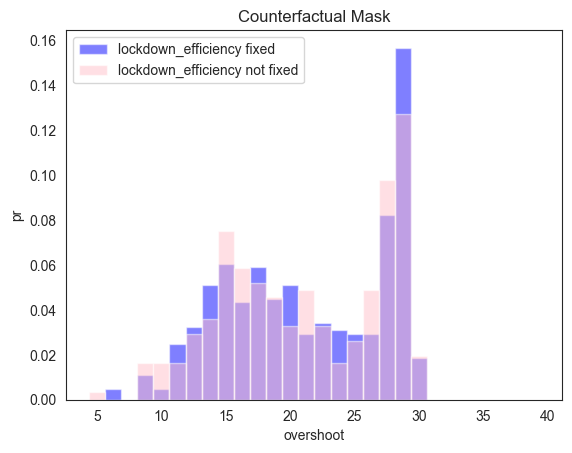

In [525]:
plt.bar(bin_edges[:28].tolist(), hist_mask_fix, align='center', width = 35/28, alpha = 0.5, color='blue')
plt.bar(bin_edges[:28].tolist(), hist_mask_notfix, align='center', width = 35/28, alpha = 0.5, color='pink')
plt.legend(["lockdown_efficiency fixed", "lockdown_efficiency not fixed"])
plt.ylabel("pr")
plt.xlabel("overshoot")
plt.title("Counterfactual Mask")
sns.despine

print("Overshoot mean")
print("lockdown_efficiency fixed: ", os_mask_fix.item(), " lockdown_efficiency not fixed: ", os_mask_notfix.item())

print("Probability of overshoot being high")
print("lockdown_efficiency fixed: ", oth_mask_fix.item(), " lockdown_efficiency not fixed: ", oth_mask_notfix.item())